In [1]:
#import relevant packages for analysis

from __future__ import print_function

import os
import sys


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('talk')
import random
from scipy.stats import randint

PROJ_ROOT = os.path.join(os.pardir)

In [2]:
%load_ext watermark
%watermark -a "Bryan Dickinson" -d -t -v -p numpy,pandas,scikitlearn

Bryan Dickinson 2019-08-07 13:40:14 

CPython 3.7.3
IPython 7.7.0

numpy 1.16.4
pandas 0.25.0
scikitlearn not installed


## Machine Learning & Terry Stops

Under the 1968 Terry v. Ohio ruling , a police officer may stop and detain a person based on ***reasonable suspicion***. And, if the police reasonably suspect the person is armed and dangerous, they may also frisk him or her for weapons.

**What exactly is Reasonable Suspicion?**

Reasonable suspicion is defined by a set of factual circumstances that would lead a reasonable police officer to believe criminal activity is occurring. This is different from the probable cause (what a reasonable person would believe) required for an arrest, search, and seizure. If the stop and frisk gives rise to probable cause to believe the detainee has committed a crime, then the police officer should have the power to make a formal arrest and conduct a search of the person.

**A Justified Stop**

A stop is justified if the suspect is exhibiting any combination of the following behaviors:

- Appears not to fit the time or place.
- Matches the description on a "Wanted" flyer.
- Acts strangely, or is emotional, angry, fearful, or intoxicated.
- Loitering, or looking for something.
- Running away or engaging in furtive movements.
- Present in a crime scene area.
- Present in a high-crime area (not sufficient by itself or with loitering).

A few of these behaviors can be subjective. 

Can the race of a subject be predicted based on the demographics of the officer, age/gender of the subject and where the stop was performed?

In [3]:
#Create the path to the data and read into a pandas dataframe

terry_data = os.path.join(PROJ_ROOT, 
                         'data', 'processed',
                         'Terry_Stops_Clean.csv')

data = pd.read_csv(terry_data, parse_dates = ['date'], 
                   index_col = 'date', dtype = {'officer_race':'category','officer_gender':'category',
                                                'subject_age':'category',
                                                'subject_race':'category','subject_gender': 'category',
                                                'stop_resolution': 'category','weapon_type':'category',
                                                'call_type':'category','arrest':'int32', 'frisk':'float',
                                                'precinct':'category', 'sector':'category', 'beat': 'category'})

data.sort_index(inplace = True)

In [4]:
def split_mean(x):
    #Function to split the Age bins and return the mean of the two numbers
        if '-' in x:
            split_list = x.split('-')
            mean = (float(split_list[0]) + float(split_list[1]))/2
        else:
            mean = 56
        return mean


In [5]:
columns_to_drop = ['officer_id','officer_squad','stop_resolution',
                   'weapon_type','call_type', 'arrest', 'frisk',
                   'precinct', 'sector','subject_id', 'initial_call_type']


In [6]:
df = data.drop(columns_to_drop, axis = 1)

df.head()

,officer_age,officer_race,officer_gender,subject_age,subject_race,subject_gender,beat
date,,,,,,,
2015-03-15,60.0,Hispanic or Latino,M,1 - 17,Black,Female,NaN
2015-03-16,31.0,White,M,18 - 25,Black,Male,NaN
2015-03-16,38.0,White,M,36 - 45,Multi-Racial,Male,NaN
2015-03-16,38.0,White,M,18 - 25,White,Male,NaN
2015-03-17,38.0,White,M,26 - 35,White,Male,NaN


In [7]:
#replace age bins with the mean for the subject_age column
df['subject_age'] = df.subject_age.apply((split_mean))
df.head()

,officer_age,officer_race,officer_gender,subject_age,subject_race,subject_gender,beat
date,,,,,,,
2015-03-15,60.0,Hispanic or Latino,M,9.0,Black,Female,NaN
2015-03-16,31.0,White,M,21.5,Black,Male,NaN
2015-03-16,38.0,White,M,40.5,Multi-Racial,Male,NaN
2015-03-16,38.0,White,M,21.5,White,Male,NaN
2015-03-17,38.0,White,M,30.5,White,Male,NaN


In [8]:
# the beat feature has 12,380 NaN values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34050 entries, 2015-03-15 to 2019-05-07
Data columns (total 7 columns):
officer_age       34050 non-null float64
officer_race      34050 non-null category
officer_gender    34050 non-null category
subject_age       33362 non-null category
subject_race      34050 non-null category
subject_gender    34034 non-null category
beat              21670 non-null category
dtypes: category(6), float64(1)
memory usage: 735.6 KB


In [9]:
# removing the 'Unkown' & 'Other' entries for the target variable

df = df[(df.subject_race != 'Unknown') & (df.subject_race != 'Other')]


In [10]:
# it appears the majority of values are a letter followed by a number
# There are values that do not stick to this standard, these values will be removed.

df.beat.unique()

[NaN, E3, G3, E2, G2, ..., S, CTY, INV, N, W]
Length: 58
Categories (57, object): [E3, G3, E2, G2, ..., CTY, INV, N, W]

In [11]:
import re

#create the pattern to match the beat entries
pattern = re.compile( '^[A-Z][1-9]$')

#drop any NaNs in the beat column
df = df.dropna(subset = ['beat'])

#use the pattern created to subset the data and get rid of the erroneous entries
df = df[(df.beat.str.contains(pattern))]

In [12]:
#drop NaN values in the dataframe
df.dropna(inplace = True)

#remove all unused categories
for col in df.select_dtypes(include = ['category']).columns:
    df[col] = df[col].cat.remove_unused_categories()

    

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20276 entries, 2015-03-17 to 2019-05-07
Data columns (total 7 columns):
officer_age       20276 non-null float64
officer_race      20276 non-null category
officer_gender    20276 non-null category
subject_age       20276 non-null category
subject_race      20276 non-null category
subject_gender    20276 non-null category
beat              20276 non-null category
dtypes: category(6), float64(1)
memory usage: 439.5 KB


N3    982
E2    935
K3    748
M3    695
M2    636
Name: beat, dtype: int64


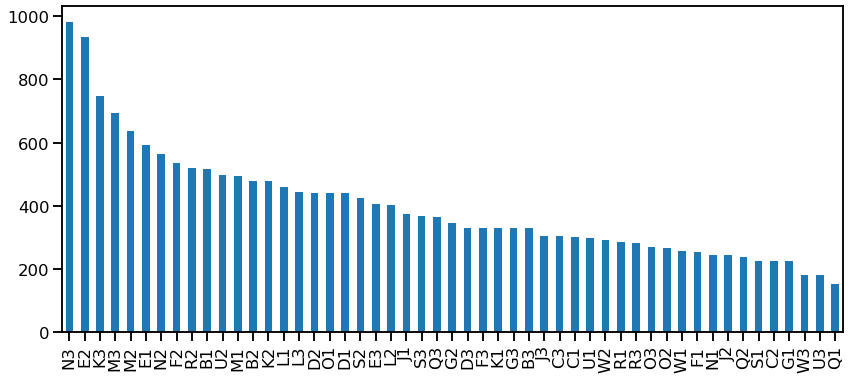

In [13]:
#investigate the distibution of beats

top_beats = df.beat.value_counts().head(5)
print(top_beats)

plt.figure(figsize = (14,6))
df.beat.value_counts().plot(kind='bar')

The NaNs in the 'beat' column have been dropped even though they were a large portion of the data. There is no beat that makes up the majority of the data. The top 5 beats account for 19% of the data, the top beat 'N3' is 5% of the data . These 5 beats are located in 5 different sectors. It would not make sense to lump the NaNs that were removed (that made up 36% of the data) into a sector that 5% or less of the data. At this time, the model will be made without this data.

In [14]:
#find the occurence of each label
df.subject_race.value_counts()

White                               10488
Black                                6898
Hispanic                             1033
American Indian / Alaskan Native      715
Asian                                 654
Multi-Racial                          488
Name: subject_race, dtype: int64

Some labels/racies appear in a low percentage of the total, the smaller target classes will be upsampled during the pipeline.

In [15]:
labels_to_use = pd.get_dummies(df['subject_race'])


Can we predict the race of a sujbect of an officer's arrest?

In [16]:
len(df['subject_race'])

20276

In [17]:
race_cat_codes = dict(enumerate(df['subject_race'].cat.categories))
race_cat_codes

{0: 'American Indian / Alaskan Native',
 1: 'Asian',
 2: 'Black',
 3: 'Hispanic',
 4: 'Multi-Racial',
 5: 'White'}

In [18]:
list(df.subject_race.unique())
type(df['subject_race'].cat.codes)

pd.DataFrame({'race':df['subject_race'],
             'code':df['subject_race'].cat.codes}).head(3)

,race,code
date,,
2015-03-17,White,5
2015-03-17,Black,2
2015-03-17,White,5


In [19]:
def compute_log_loss(predicted, actual, eps = 1e-14):
    #computes the logarithmic loss between predicted and actual when these are 1d arrays
    predicted = np.clip(predicted, eps, 1-eps)
    loss = -1 * np.mean(actual * np.log(predicted)
                       + (1 - actual)
                       * np.log(1-predicted))
    return loss

# Build the Classifier
Can the race of a subject be predicted based on the demographics of the officer, and age/gender of the subject?

In [20]:
#import relevent classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


#import preprocessing, metrics & pipelines
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, roc_curve, roc_auc_score


In [21]:
#The metric that will be used is log loss. log loss is a log function is a measure of error. 
#The error should be as small as possible.

def compute_log_loss(predicted, actual, eps = 1e-14):
    #computes the logarithmic loss between predicted and actual when these are 1d arrays
    predicted = np.clip(predicted, eps, 1-eps)
    loss = -1 * np.mean(actual * np.log(predicted)
                       + (1 - actual)
                       * np.log(1-predicted))
    return loss

def consolidate_array(arr, cols = [0,1,2,3,4,5]):
    #function to transform the dummies array to a single column
    
    df = pd.DataFrame(arr, columns = cols)
    return(df.idxmax(axis = 1).values)

In [22]:

#set up the target variable
dummy_labels = pd.get_dummies(df['subject_race']).values
#dummy_labels = df.reset_index(drop = True)['subject_race'].cat.codes

#set the x variables by converting the categorical text features to dummy variables
features = pd.get_dummies(df.reset_index(drop = True).drop(['subject_race'], axis = 1),
                          columns = ['officer_race','officer_gender',
                                     'subject_gender', 'beat'] )


In [23]:
print(features.shape)
print(dummy_labels.shape)

(20276, 66)
(20276, 6)


In [24]:
#split the data to test & training sets
X_train, X_test, y_train, y_test = train_test_split(features, dummy_labels, test_size = 0.2, 
                                                    random_state = 5, stratify = dummy_labels)


#build the pipline with upsampling & scaling the data
pipeline = imbPipeline([('sm', SMOTE(random_state = 5,
                                     sampling_strategy = 'not majority')),
               ('scale', StandardScaler()),
               ('clf', OneVsRestClassifier(LogisticRegression()))
              ])

#paramters for tuning
parameters = [
    {'clf' : [ OneVsRestClassifier(LogisticRegression(random_state = 5))],
    'clf__estimator__C' : np.logspace(-5, 8, 10),
    'clf__estimator__solver' : ['lbfgs', 'sag']},
    {'clf' : [ OneVsRestClassifier(RandomForestClassifier(random_state = 5))],
    'clf__estimator__max_depth':[3, None],
    'clf__estimator__n_estimators' : [10,25,100,120],
    'clf__estimator__max_features' : ['auto', 2, 4]},
    {'clf' : [OneVsRestClassifier(KNeighborsClassifier())],
     'clf__estimator__n_neighbors' : [5,10,15]}
    
]


#create the grid search object
cv = GridSearchCV(pipeline,
                  param_grid=parameters,
                  cv = 5, 
                  scoring = 'neg_log_loss', #set scoring to  log loss for the multi classfication model
                  refit = True,  #set refit to true to obtain the score of GridSearchCV
                  verbose = True,
                  n_jobs = -1)
# fit the model
cv.fit(X_train, y_train)


# predict on the test set
y_pred = cv.predict(X_test)

# obtain the prediction probabilities
y_predict_proba = cv.predict_proba(X_test)



Fitting 5 folds for each of 47 candidates, totalling 235 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 39.5min
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed: 66.4min finished


In [25]:
#observe the best estimator / pipeline
cv.best_estimator_

Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=5, ratio=None,
                       sampling_strategy='not majority',
                       svm_estimator='deprecated')),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                      class_weight=None,
                                                                      criterion='gini',
                                                                      max_depth=3,
                                                                      max_features='auto',
                                                                      max_leaf_nodes=None,
 

In [26]:
consolidate_array(y_test)
consolidate_array(y_pred)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [27]:
acc_score = cv.score(X_test, y_test)  #obtain accuracy score
log_loss = compute_log_loss(y_predict_proba, y_test)  #log loss score


print('The accuracy score is: {}'.format(acc_score))
print('The log loss is {}'.format(log_loss))

#consolidate the arrays to one column with the original cat code values during pre processing for
#ease of reading the confusion matrix
print(confusion_matrix(consolidate_array(y_test), consolidate_array(y_pred), labels = [0,1,2,3,4,5]))

The accuracy score is: -1.6717546472157405
The log loss is 0.42614124538737025
[[ 143    0    0    0    0    0]
 [ 131    0    0    0    0    0]
 [1380    0    0    0    0    0]
 [ 207    0    0    0    0    0]
 [  97    0    0    0    0    0]
 [2098    0    0    0    0    0]]


In [28]:
# attach the predicted probabilities with the actual values into one dataframe to visually observe the results
pred_df = pd.concat([pd.DataFrame(y_predict_proba),
                      pd.DataFrame(y_test)], 
                     ignore_index = True,
                     axis = 1)

pred_df.columns = ['0','1','2','3','4','5', 'act_0','act_1','act_2','act_3','act_4','act_5']
pred_df.head()

,0,1,2,3,4,5,act_0,act_1,act_2,act_3,act_4,act_5
0,0.154530,0.157748,0.159362,0.156096,0.139727,0.316100,0,0,0,0,0,1
1,0.152234,0.147981,0.173927,0.160371,0.145964,0.154825,0,0,0,0,0,1
2,0.141139,0.160153,0.174384,0.162821,0.131216,0.158516,0,0,0,0,0,1
3,0.183808,0.119775,0.256353,0.144826,0.164465,0.203998,0,0,0,1,0,0
4,0.129007,0.163302,0.186953,0.165183,0.165276,0.155468,0,0,0,0,0,1


In [29]:

#obtain the feature importances from within the GridSearchCV, pipeline, & OneVsRest objects
fi = [x.feature_importances_ for x in cv.best_estimator_.steps[2][1].estimators_]
fi = np.mean(fi, axis = 0)

#place the feature importances in a dataframe
feature_importances = pd.DataFrame(fi,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(3)

,importance
subject_gender_Female,0.068424
beat_S2,0.056828
subject_gender_Male,0.054288


# Findings

Log-Loss is used as the performance metric for this model. It takes into account he uncertainty of the prediction based on how much the prediction varies from the actual label. 

The accruacy of the model is -1.67, and log loss is .426. The uninformative value for log loss for a balanced dataset with six classes 1.79. The log loss for this model is below the value of 1.79, however the model does not explain the variance well. The predictions observed were well below the threshold to confidently predict any  one class, as seen from the confusion matrix. For all all classes, a 0 was predicted, confirming the low confidence in each class and resulting in the low accuracy score.

This leads me be to beleive that more information is needed to predict the race of a stopped subject than only the demographic information & stop location.

For instance the features of 'time of day' or 'call type' may have a more significant impact on if a subject does not fit the 'time or place' to justify a stop.

This model also lumps all officers into the same model, deciding on the demographic information of the officers & subjects only. However one person can have a certain bias, while a person within the same race may not have that same bias.
